# Estimation with sensor offset and drift

_This is based on a problem presented in EE 263 Linear Dynamical Systems at Stanford University_

### Background: Least Squares

Suppose that we are trying to estimate a vector $p\in\mathbf{R}^{n}$. We take $m$ scalar measurements, each a linear combination of elements of $p$. Each measurement, $y_i$, is modeled as

\begin{align}
y_i = a_i^T p + v_i,\quad\quad i=1,\ldots,m,
\end{align}

where

- $y_i\in\mathbf{R}$ is the $i^{\text{th}}$ measurement
- $p\in\mathbf{R}^n$ is vector we wish to measure
- $v_i$ is the sensor or measurement error of the ith measurement.

We assume that the $a_i$'s are given, i.e. we know the calibration values of the sensor for each measurement. Additionally, we assume that we have at least as many measurements as values we need to estimate $\left(m\geq n\right)$ and that the matrix A given by

\begin{align}
A = \left[\begin{matrix}
a_1^T \\ a_2^T \\ \vdots \\ a_m^T
\end{matrix}\right]
\end{align}

is full rank. For standard linear regression, the vector $x$ would be in $\mathbf{R}^2$ and would represent the slope and intercept parameters. In this context, the matrix $A$ would have the given values for the independent variable in the first column and all ones in the second column, and the vector $y\in\mathbf{R}^m$ would contain the values for the dependent variable. If the error terms, $v_i$, were small, random, and centered around zero (Gaussian white noise), then least squares gives the optimal estimation of x (i.e., minimizes the RMSE):

\begin{align}
\hat{p} = \left(A^TA\right)^{-1}A^T y = \underset{p}{\text{argmin}}\left\lVert y - Ap \right\rVert_2^2
\end{align}

Let's illustrate this with a quick example.

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')

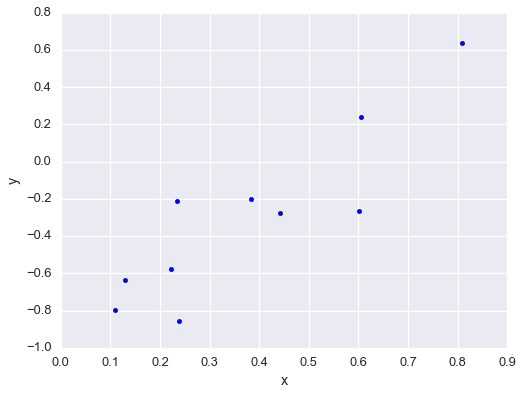

In [2]:
m = 2
b = -1
xs = np.random.uniform(0, 1, 10)
ys = m * xs + b + np.random.normal(0, .2, size=len(xs))
fig = plt.figure(figsize=(8,6))
plt.scatter(xs, ys)
plt.xlabel('x'); plt.ylabel('y')
plt.show()

Construct the matrix $A$.

In [3]:
A = np.c_[xs, np.ones_like(xs)]
print A

[[0.12997784 1.        ]
 [0.10977849 1.        ]
 [0.60488689 1.        ]
 [0.38266506 1.        ]
 [0.60065919 1.        ]
 [0.44154635 1.        ]
 [0.23412023 1.        ]
 [0.8084878  1.        ]
 [0.22136882 1.        ]
 [0.23757838 1.        ]]


Solve the least squares problem.

In [4]:
p_hat = inv(A.T.dot(A)).dot(A.T).dot(ys)

Compared the estimated parameters to the real parameters.

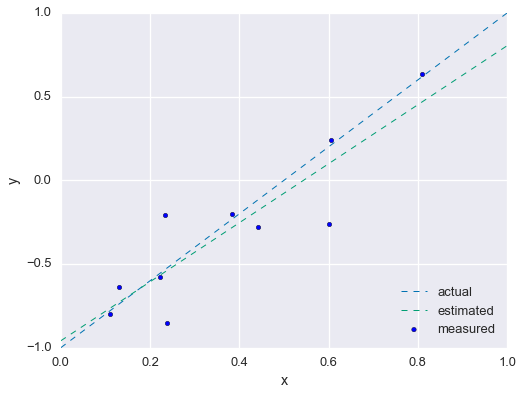

In [5]:
fig = plt.figure(figsize=(8,6))
plt.scatter(xs, ys, label='measured')
x2 = np.linspace(0, 1)
plt.plot(x2, m*x2 + b, linewidth=1, ls='--', label='actual')
plt.plot(x2, p_hat[0]*x2 + p_hat[1], linewidth=1, ls='--', label='estimated')
plt.xlabel('x'); plt.ylabel('y')
plt.xlim(0, 1); plt.ylim(-1, 1)
plt.legend(loc=4)
plt.show()

### Adding bias and drift to the error

For this problem, let us assume that the error contains some predictable terms in addition to white noise: a common offset term that is the same for all measurements and a drift term that grows linearly with each subsequent measurement. We model this situation as:

\begin{align}
v_i = \alpha + \beta i + w_i
\end{align}

We will use least squares to simultaneously the desired vector $x\in\mathbf{R}^n$, the bias term $\alpha\in\mathbf{R}$, and the drift term $\beta\in\mathbf{R}$. We begin by substituting our error model into the measurement model:

\begin{align}
y_i = a_i^T x + \alpha + \beta i + w_i,\quad\quad i=1,\ldots,m,
\end{align}

This induces the matrix equation:

\begin{align}
\left[\begin{matrix}
y_1 \\ y_2  \\ \vdots \\ y_m
\end{matrix}\right] &= 
\left[\begin{matrix}
a_1^T & 1 & 1 \\
a_2^T & 1 & 2 \\
\vdots & \vdots & \vdots \\
a_m^T & 1 & m
\end{matrix}\right]
\left[\begin{matrix}
x \\ \alpha \\ \beta
\end{matrix}\right] + 
\left[\begin{matrix}
w_1 \\ w_2 \\ \vdots \\ w_m
\end{matrix}\right] \\ \\
y &= \tilde{A}\tilde{x} + w
\end{align}

We can now use least squares to find all parameters:

\begin{align}
\hat{\tilde{x}} = \left[\begin{matrix}
\hat{x} \\ \hat{\alpha} \\ \hat{\beta}
\end{matrix}\right] = \left(\tilde{A}^T\tilde{A}\right)^{-1}\tilde{A}^T y
\end{align}

Alright! We have a closed-form expression to estimate $x$, $\alpha$, and $\beta$. A couple caveats: for this to work, the following much be true:

- $m\geq n +2$. We must have enough measurement to recover $n+2$ parameters.
- $\tilde{A}$ must be full rank. Note, even if $A$ is full rank (which is given), $\tilde{A}$ might not be. If some linear combination of the sensor signals looks like some linear combination of the offset and drift, then it is impossible to separate the offset and drift parameters from $x$. 

Immediately, we see a potential problem! If we are using this to derive the parameters of a statistical model (as in the previous example), that model can't contain an offset term! If it does, then the second condition is violated.

Alright, that's enough theory. Now let's look at an application of this technique. Again, suppose we have some noisy measurements of a function. This time we'll make the function a bit more interesting: a cubic function with no offset. We'll start by again looking at the simpler case where the noise terms are i.i.d. Gaussian white noise, and then we'll add the offset and drift terms.

In [6]:
def our_func(x, p1=1, p2=3, p3=-0.2):
    output = p1 * x + p2 * np.power(x, 2) + p3 * np.power(x, 3)
    return output

In [7]:
np.random.seed(42)

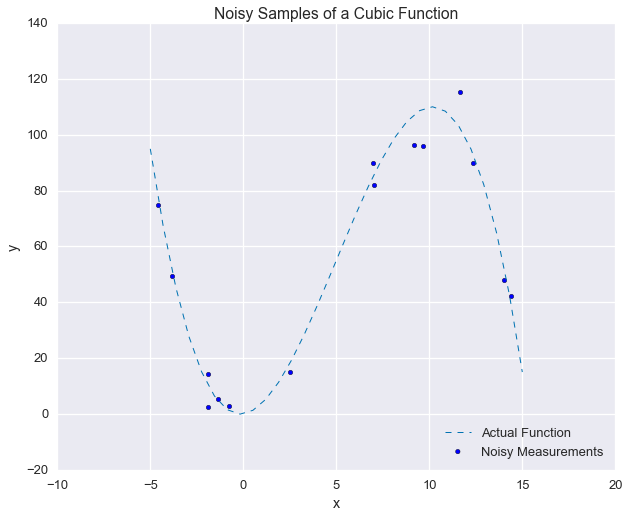

In [8]:
fig = plt.figure(figsize=(10, 8))
xs_ideal = np.linspace(-5, 15, 30)
xs_samples = np.random.uniform(-5, 15, 15)
ys_samples = our_func(xs_samples) + np.random.normal(0, 5, size=len(xs_samples))
plt.plot(xs_ideal, our_func(xs_ideal), linewidth=1, ls='--')
plt.scatter(xs_samples, ys_samples)
plt.legend(['Actual Function', 'Noisy Measurements'], loc=4)
plt.xlabel('x'); plt.ylabel('y')
_ = plt.title('Noisy Samples of a Cubic Function')

A cubic function with no offset is fully defined by three scalar coefficients:

\begin{align}
y = \mathcal{P}_3(x) &= p_1 x + p_2 x^2 + p_3 x^3 \\
&= \left[\begin{matrix} x & x^2 & x^3 \end{matrix}\right] \left[\begin{matrix} p_1 \\ p_2 \\ p_3 \end{matrix}\right]
\end{align}

So, given a set of noisy measurement, $\left\{\left(x_1, y_1\right),\left(x_2, y_2\right),\ldots, \left(x_m, y_m\right)\right\}$, we find $p=\left[\begin{matrix}p_1 & p_2 & p_3\end{matrix}\right]^T$ as follows. First, construct the following matrix:

\begin{align}
A &= \left[\begin{matrix}
x_1 & x_1^2 & x_1^3 \\
x_2 & x_2^2 & x_2^3 \\
\vdots & \vdots & \vdots \\
x_m & x_m^2 & x_m^3 \\
\end{matrix}\right]
\end{align}

Then, find $\hat{p}$ as before:

\begin{align}
\hat{p} = \left(A^TA\right)^{-1}A^T y = \underset{p}{\text{argmin}}\left\lVert y - Ap \right\rVert_2^2
\end{align}

Let's try it out on this cubic-fitting problem! As before, start by constructing matrix $A$.

In [9]:
A = np.c_[xs_samples, np.power(xs_samples, 2), np.power(xs_samples, 3)]
np.set_printoptions(precision=2)
print A

[[ 2.49e+00  6.20e+00  1.55e+01]
 [ 1.40e+01  1.96e+02  2.75e+03]
 [ 9.64e+00  9.29e+01  8.96e+02]
 [ 6.97e+00  4.86e+01  3.39e+02]
 [-1.88e+00  3.53e+00 -6.64e+00]
 [-1.88e+00  3.53e+00 -6.65e+00]
 [-3.84e+00  1.47e+01 -5.65e+01]
 [ 1.23e+01  1.52e+02  1.87e+03]
 [ 7.02e+00  4.93e+01  3.46e+02]
 [ 9.16e+00  8.39e+01  7.69e+02]
 [-4.59e+00  2.11e+01 -9.66e+01]
 [ 1.44e+01  2.07e+02  2.98e+03]
 [ 1.16e+01  1.36e+02  1.58e+03]
 [-7.53e-01  5.67e-01 -4.27e-01]
 [-1.36e+00  1.86e+00 -2.53e+00]]


Then, solve the least squares problem.

In [10]:
p_hat = inv(A.T.dot(A)).dot(A.T).dot(ys_samples)
print p_hat

[ 0.96  2.88 -0.19]


Recall, that the actual parameters were $\left[1, 3, -0.2\right]$. Let's compare the results.

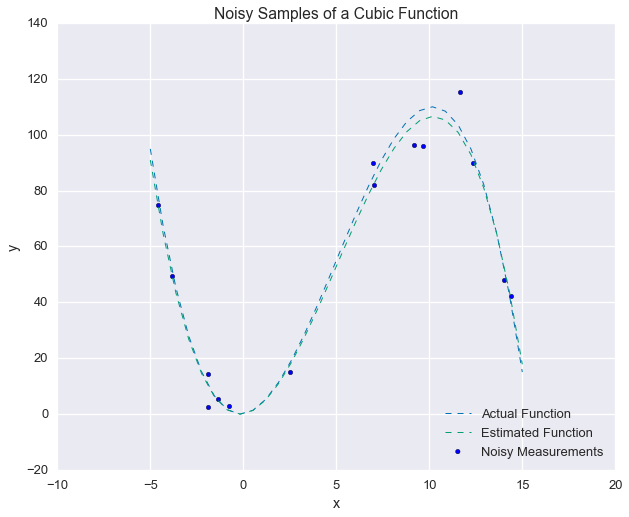

In [11]:
fig = plt.figure(figsize=(10, 8))
plt.plot(xs_ideal, our_func(xs_ideal), linewidth=1, ls='--', label='Actual Function')
plt.plot(xs_ideal, our_func(xs_ideal, p1=p_hat[0], p2=p_hat[1], p3=p_hat[2]),
         linewidth=1, ls='--', label='Estimated Function')
plt.scatter(xs_samples, ys_samples, label='Noisy Measurements')
plt.legend(loc=4)
plt.xlabel('x'); plt.ylabel('y')
_ = plt.title('Noisy Samples of a Cubic Function')

That's pretty good! Now let's make things interesting and include the offset and drift terms. The existing formulation already includes Gaussian white noise, so there's no need to add that again.

In [12]:
alpha = -3
beta = 5

In [13]:
ys_od = ys_samples + alpha + beta * np.arange(1, 1 + A.shape[0])

As a sanity check, here's what the measurements look like now, as compared to the actual function:

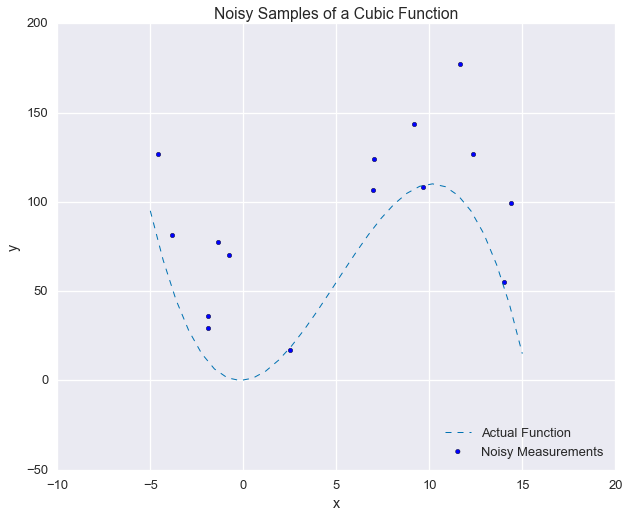

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.plot(xs_ideal, our_func(xs_ideal), linewidth=1, ls='--', label='Actual Function')
plt.scatter(xs_samples, ys_od, label='Noisy Measurements')
plt.legend(loc=4)
plt.xlabel('x'); plt.ylabel('y')
_ = plt.title('Noisy Samples of a Cubic Function')

Yikes! That looks like a mess. We might not think we would have any chance of recovering the original function from these measurements, but we'll see that correctly modeling the error saves the day.

First, we construct the augmented matrix $\tilde{A}$.

In [15]:
A_tilde = np.concatenate([
    A,
    np.ones(A.shape[0])[:, None],
    np.arange(1, 1 + A.shape[0])[:, None]
], axis = 1)
print A_tilde

[[ 2.49e+00  6.20e+00  1.55e+01  1.00e+00  1.00e+00]
 [ 1.40e+01  1.96e+02  2.75e+03  1.00e+00  2.00e+00]
 [ 9.64e+00  9.29e+01  8.96e+02  1.00e+00  3.00e+00]
 [ 6.97e+00  4.86e+01  3.39e+02  1.00e+00  4.00e+00]
 [-1.88e+00  3.53e+00 -6.64e+00  1.00e+00  5.00e+00]
 [-1.88e+00  3.53e+00 -6.65e+00  1.00e+00  6.00e+00]
 [-3.84e+00  1.47e+01 -5.65e+01  1.00e+00  7.00e+00]
 [ 1.23e+01  1.52e+02  1.87e+03  1.00e+00  8.00e+00]
 [ 7.02e+00  4.93e+01  3.46e+02  1.00e+00  9.00e+00]
 [ 9.16e+00  8.39e+01  7.69e+02  1.00e+00  1.00e+01]
 [-4.59e+00  2.11e+01 -9.66e+01  1.00e+00  1.10e+01]
 [ 1.44e+01  2.07e+02  2.98e+03  1.00e+00  1.20e+01]
 [ 1.16e+01  1.36e+02  1.58e+03  1.00e+00  1.30e+01]
 [-7.53e-01  5.67e-01 -4.27e-01  1.00e+00  1.40e+01]
 [-1.36e+00  1.86e+00 -2.53e+00  1.00e+00  1.50e+01]]


The standard least squared estimate:

In [16]:
p_ls = inv(A.T.dot(A)).dot(A.T).dot(ys_od)
print p_ls

[-3.5   4.51 -0.27]


The least squared estimate using the noise model:

In [17]:
p_ls_plus_noise = inv(A_tilde.T.dot(A_tilde)).dot(A_tilde.T).dot(ys_od)
print p_ls_plus_noise[:3]

[ 1.16  2.86 -0.19]


And we also recover the estimates of $\alpha$ and $\beta$.

In [18]:
p_ls_plus_noise[3:]

array([-7.56,  5.57])

So, we can see that the LS estimate that utilizes the noise model does a much better job of estimating the desired parameters. What about the error? Recall the quantity we are trying to minimize is

\begin{align}
\left\lVert y- Ap\right\rVert_2^2
\end{align}

So, there are really two errors to consider:

- The value of the cost function we are minimizing via the least squares method. In a real application, this is the only error we could consider
- The root-mean-square error between the estimated functions and the actual functions, evaluated at the sample points. We are only able to this because we know the function that generated the data

Let's begin by evaluating the cost function we've minimized. 

In [19]:
J_ls = np.sum(np.power(ys_od - A.dot(p_ls), 2))
J_ls_plus_noise = np.sum(np.power(ys_od - A_tilde.dot(p_ls_plus_noise), 2))
print 'Basic LS Error:        {:.3f}'.format(J_ls)
print 'Noise model LS Error:  {:.3f}'.format(J_ls_plus_noise)

Basic LS Error:        13403.986
Noise model LS Error:  469.325


That's great! By accounting for the error, we drive the cost down by an additional 32%. That certainly seems promising. Now, let's compare to the oracle (the actual function that generated the data).

In [20]:
x = our_func(xs_samples)
x_ls = our_func(xs_samples, p1=p_ls[0], p2=p_ls[1], p3=p_ls[2])
x_ls_plus_noise = our_func(xs_samples, p1=p_ls_plus_noise[0], p2=p_ls_plus_noise[1], p3=p_ls_plus_noise[2])
err_ls = np.linalg.norm(x - x_ls)
err_ls_plus_noise = np.linalg.norm(x - x_ls_plus_noise)

In [21]:
print 'Basic LS Error:        {:.3f}'.format(err_ls)
print 'Noise model LS Error:  {:.3f}'.format(err_ls_plus_noise)

Basic LS Error:        120.583
Noise model LS Error:  8.427


As expected, the method that correctly models the error gets much closer to the oracle.

And finally, visualize the results with another plot:

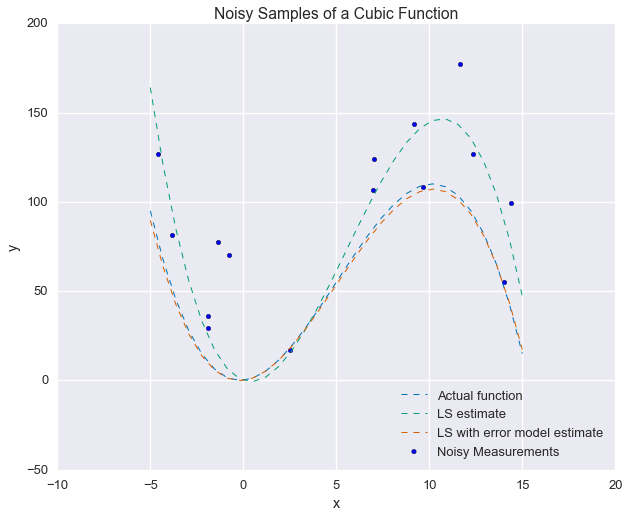

In [22]:
fig = plt.figure(figsize=(10, 8))
plt.plot(xs_ideal, our_func(xs_ideal), linewidth=1, ls='--', label='Actual function')
plt.plot(xs_ideal, our_func(xs_ideal, p1=p_ls[0], p2=p_ls[1], p3=p_ls[2]), linewidth=1, ls='--', label='LS estimate')
plt.plot(xs_ideal, our_func(xs_ideal, p1=p_ls_plus_noise[0], p2=p_ls_plus_noise[1], p3=p_ls_plus_noise[2]),
         linewidth=1, ls='--', label='LS with error model estimate')
plt.scatter(xs_samples, ys_od, label='Noisy Measurements')
plt.legend(loc=4)
plt.xlabel('x'); plt.ylabel('y')
_ = plt.title('Noisy Samples of a Cubic Function')

As a final note, I implemented$\left(A^TA\right)^{-1}A^T$ directly to emphasize the underlying equation, but this is known as the pseudoinverse of $A$ and is implemented in the NumPy linear algebra package as [pinv](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html).

In [23]:
from numpy.linalg import pinv

In [24]:
np.allclose(pinv(A), inv(A.T.dot(A)).dot(A.T))

True